In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os
import pandas as pd
import shutil

In [13]:
# Load CSV
df = pd.read_csv('reviews_rows.csv')

# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort so latest entries come last
df = df.sort_values(by='timestamp')

# Drop duplicates, keeping the latest entry per user per file
latest_df = df.drop_duplicates(subset=['username', 'filename'], keep='last')
latest_df

,id,username,filename,status,timestamp
1,2,Ethan,photos/Geisel Wall Leaning with Helmet/DSC_522...,deleted,2025-06-05 09:49:56.129524+00:00
3,4,Ethan,photos/Geisel Wall Leaning with Helmet/DSC_519...,deleted,2025-06-05 09:49:56.129524+00:00
5,6,Ethan,photos/Geisel Wall Leaning with Helmet/DSC_531...,deleted,2025-06-05 09:49:56.129524+00:00
6,7,Ethan,photos/Geisel Wall Leaning with Helmet/DSC_524...,deleted,2025-06-05 09:49:56.129524+00:00
7,8,Ethan,photos/Geisel Wall Leaning with Helmet/DSC_530...,deleted,2025-06-05 09:49:56.129524+00:00
...,...,...,...,...,...
3089,3090,Ethan,photos/Garden Robe & Helmet/DSC_6731.jpg,deleted,2025-07-15 19:13:40.158720+00:00
3088,3089,Ethan,photos/Garden Robe & Helmet/DSC_6727.jpg,deleted,2025-07-15 19:13:40.158720+00:00
3087,3088,Ethan,photos/Garden Robe & Helmet/DSC_6689.jpg,kept,2025-07-15 19:13:40.158720+00:00
3090,3091,Ethan,photos/Garden Robe & Helmet/DSC_6732.jpg,deleted,2025-07-15 19:13:40.158720+00:00


In [14]:
# Load admin CSV
admin_df = pd.read_csv('admin_reviews_rows.csv')

# Normalize path formatting
admin_df['filename'] = admin_df['filename'].str.replace('\\', '/')

# Convert status to KEEP / DELETE
admin_df['final_decision'] = admin_df['status'].map({'kept': 'KEEP', 'deleted': 'DELETE'})

# Create vote_map
vote_map_admin = dict(zip(admin_df['filename'], admin_df['final_decision']))
vote_map_admin

{'photos/All Stoles Geisel/DSC_4542.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4543.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4544.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4546.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4548.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4549.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4552.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4554.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4555.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4557.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4559.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4560.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4563.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4565.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4566.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4567.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4572.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4606.jpg': 'DELETE',
 'photos/All Stoles Geisel/DSC_4607.jpg': 'DELETE',
 'photos/All

In [15]:
latest_df['username'].value_counts()

username
Ethan    1672
Mom        80
Ash        79
Abby       75
slug       70
Umi        69
Noiz       69
monke      10
Saha       10
Name: count, dtype: int64

In [16]:
# Step 1: Get sets
ethan_votes = latest_df[latest_df['username'] == 'Ethan']
others_votes = latest_df[latest_df['username'] != 'Ethan']

# Get filenames that others reviewed
filenames_reviewed_by_others = set(others_votes['filename'])

# Group A: filenames reviewed by others (include Ethan’s votes too)
group_a = latest_df[latest_df['filename'].isin(filenames_reviewed_by_others)]

# Group B: filenames reviewed only by Ethan
ethan_only_filenames = set(ethan_votes['filename']) - filenames_reviewed_by_others
group_b = ethan_votes[ethan_votes['filename'].isin(ethan_only_filenames)]

# Map status to vote values
group_a.loc[:, 'vote'] = group_a['status'].map({'kept': 1, 'deleted': -1})

# Create matrix (rows = photos, columns = users)
vote_matrix_a = group_a.pivot(index='filename', columns='username', values='vote').fillna(0)

# Optional: prioritize photos with more reviews
vote_matrix_a['review_count'] = (vote_matrix_a != 0).sum(axis=1)
vote_matrix_a = vote_matrix_a.sort_index()
vote_matrix_a['vote_sum'] = vote_matrix_a.drop(columns=['review_count']).sum(axis=1)

C:\Users\minds\AppData\Local\Temp\ipykernel_28836\1431874527.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_a.loc[:, 'vote'] = group_a['status'].map({'kept': 1, 'deleted': -1})


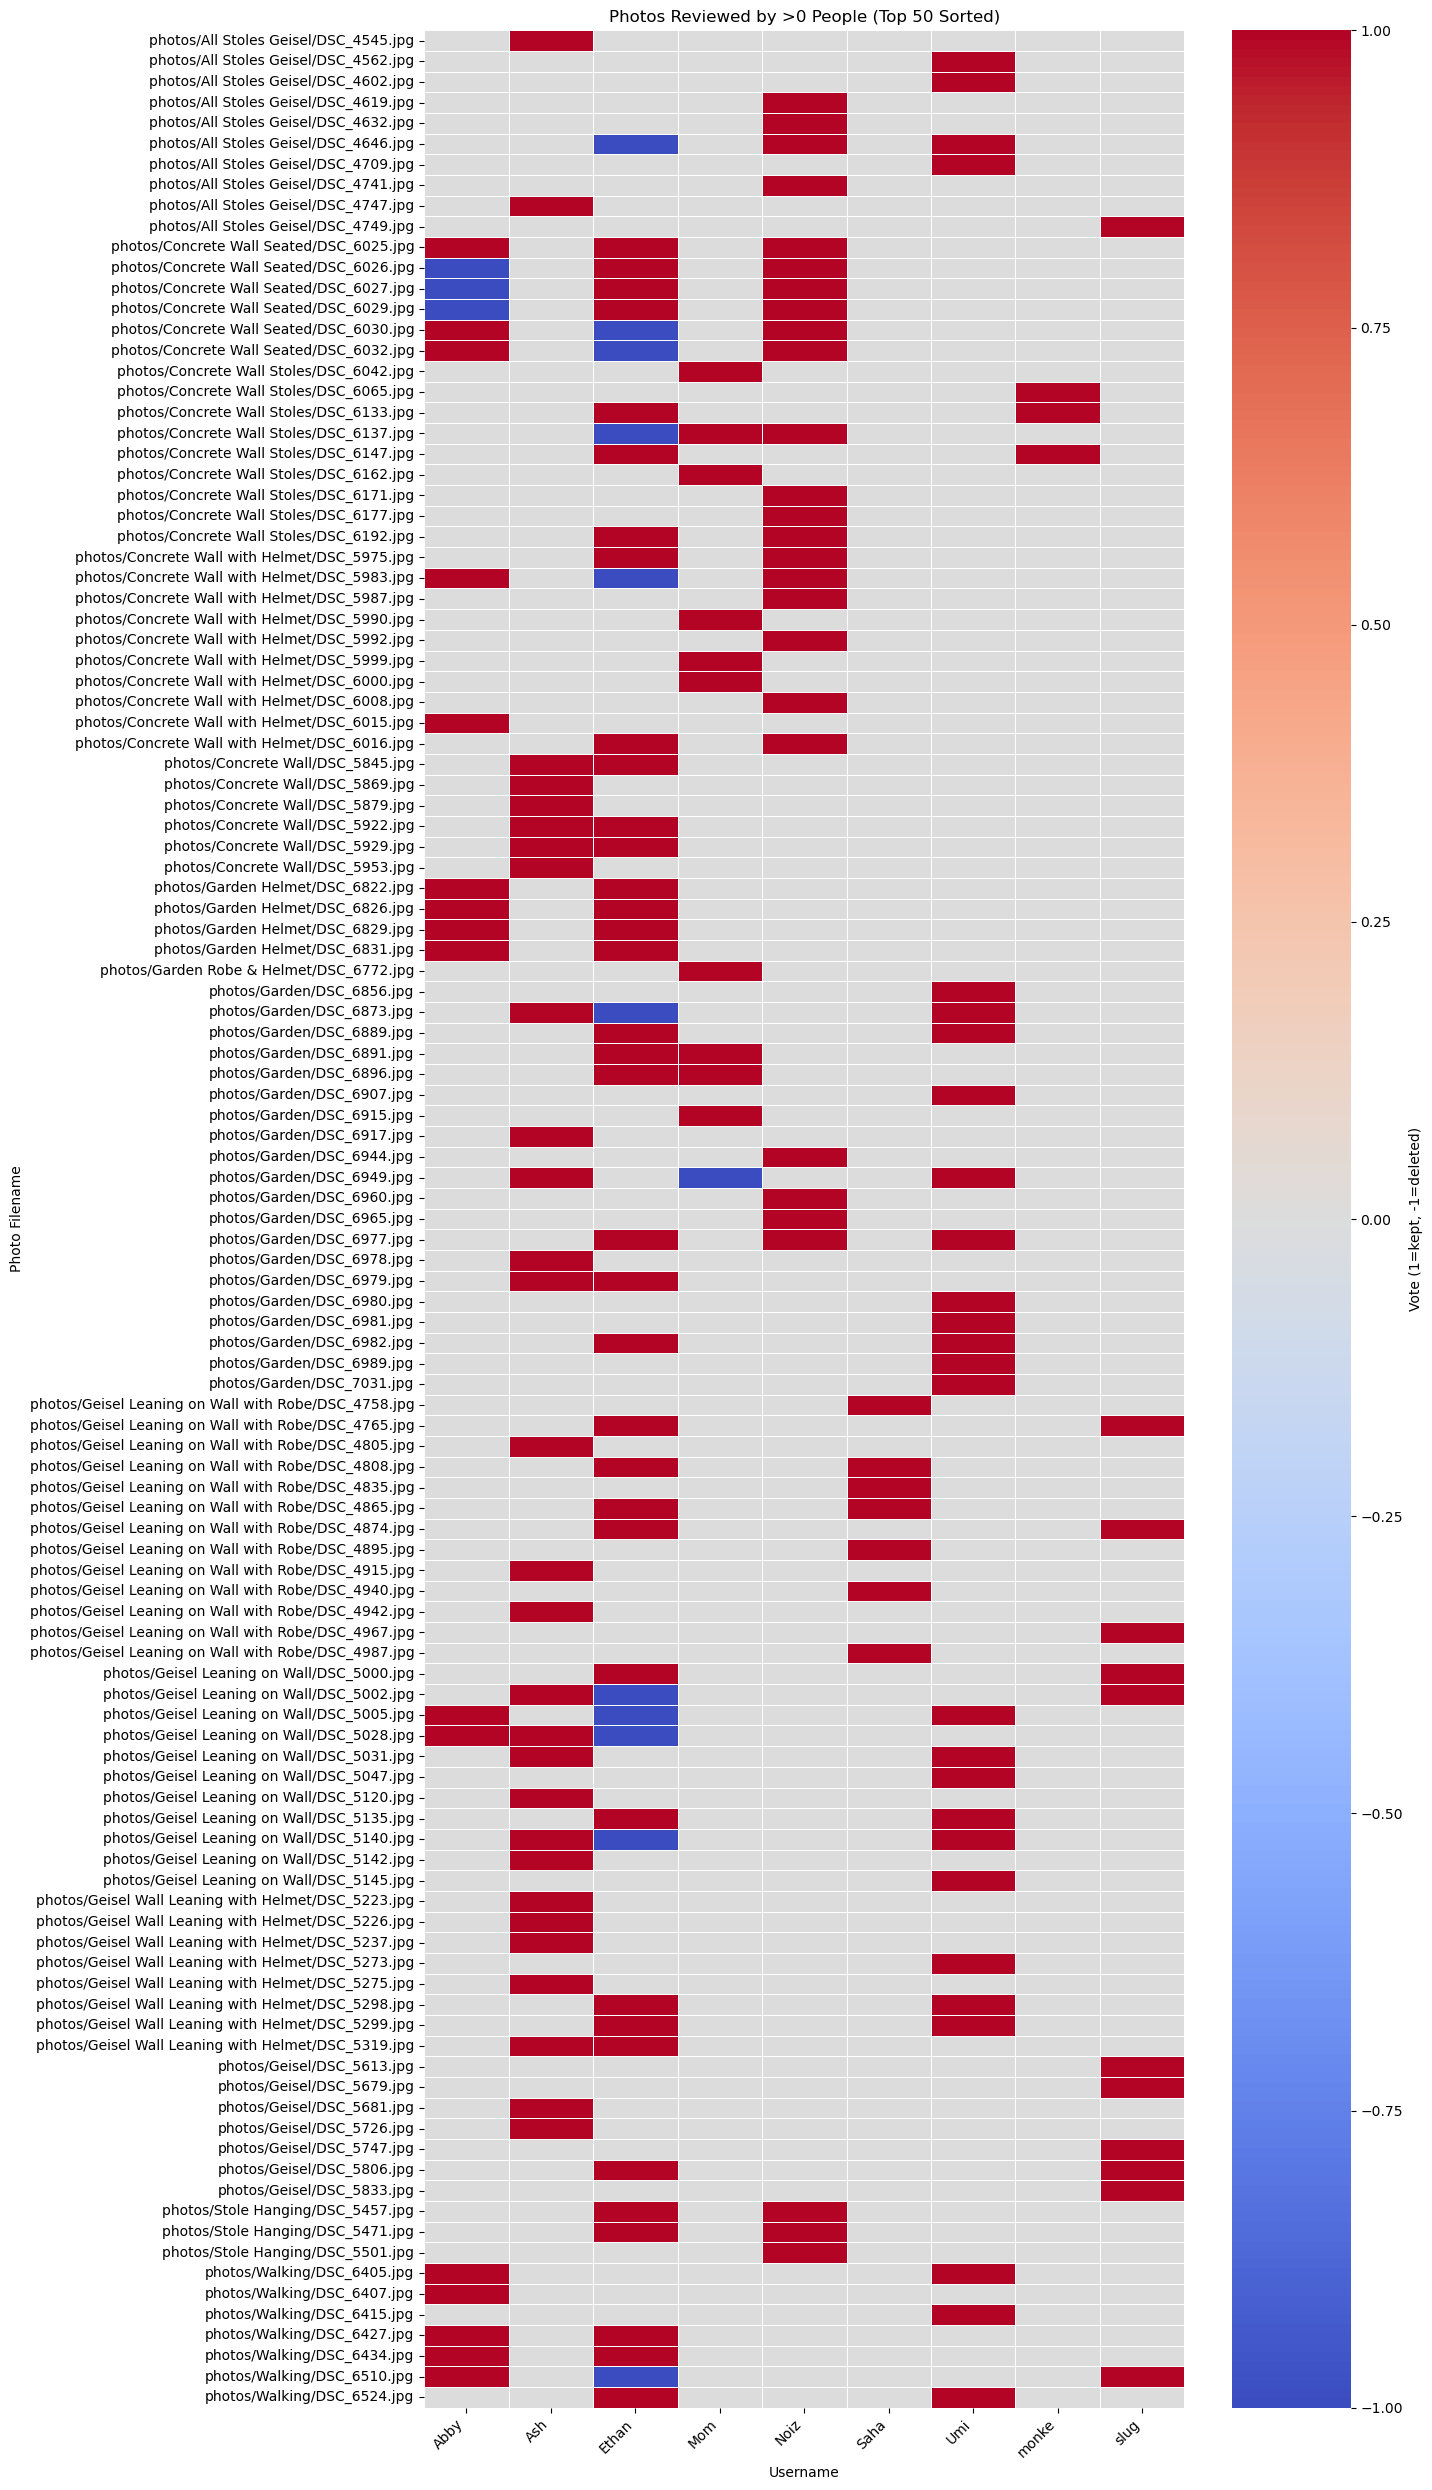

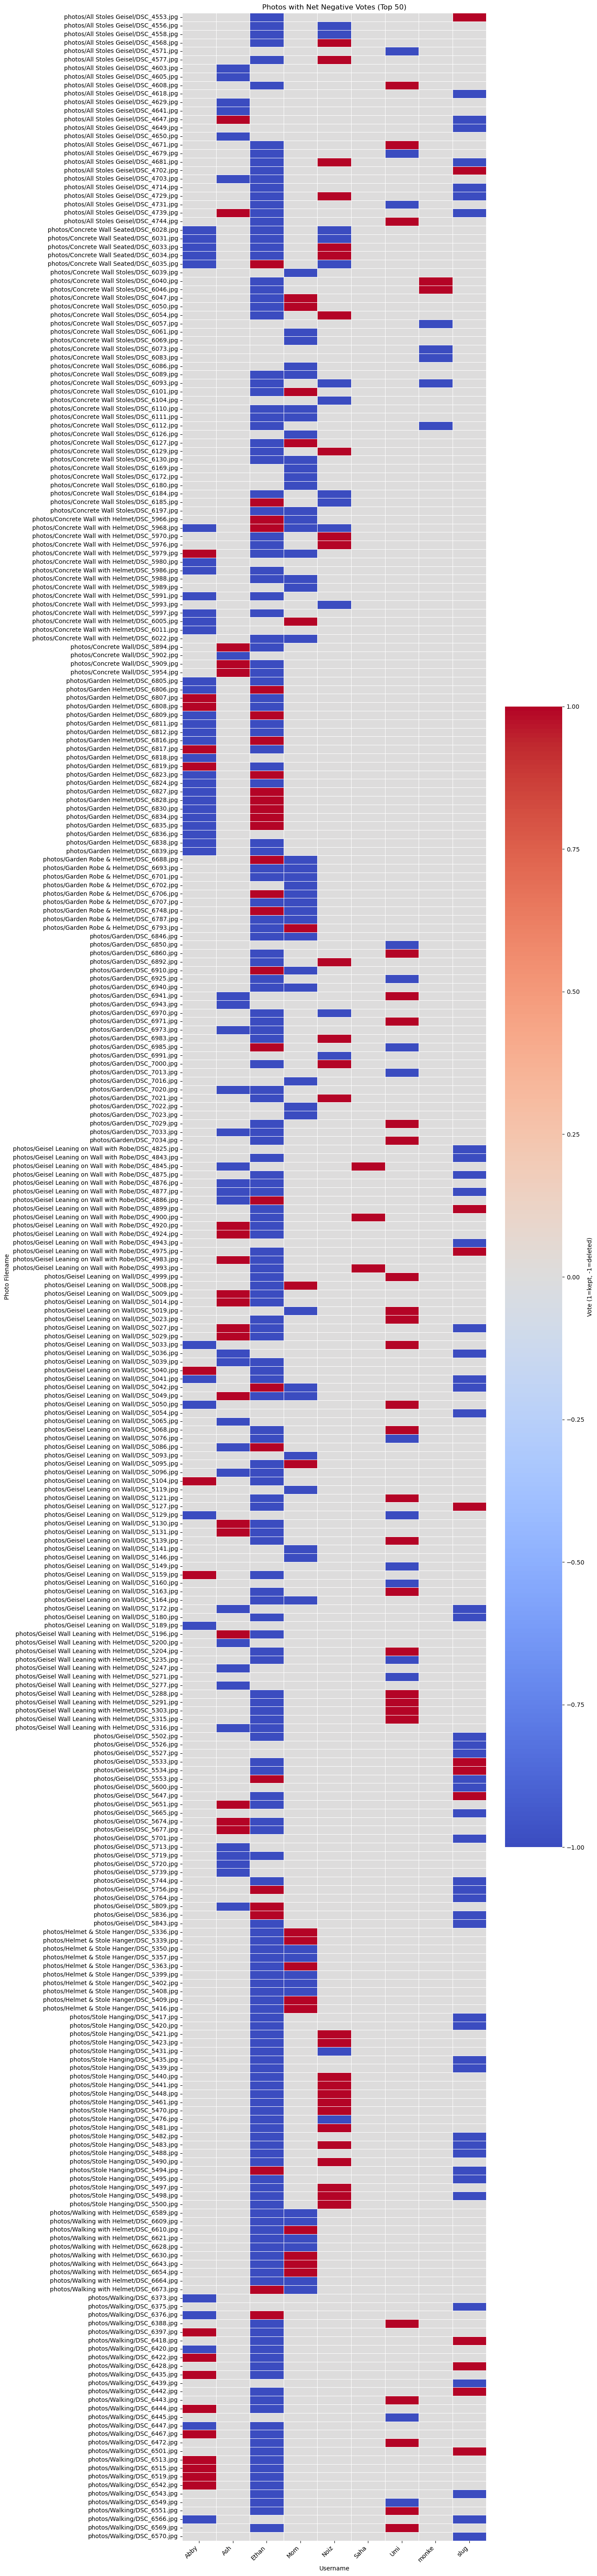

In [17]:
gt0 = vote_matrix_a[vote_matrix_a['vote_sum'] > 0].drop(columns=['review_count', 'vote_sum']).sort_index()
lt0 = vote_matrix_a[vote_matrix_a['vote_sum'] <= 0].drop(columns=['review_count', 'vote_sum']).sort_index()

def plot_heatmap(data, title, height):
    if data.empty:
        print(f"No data to display for: {title}")
        return
    plt.figure(figsize=(14, height))  # Auto-scale height
    sns.heatmap(data, cmap='coolwarm', center=0, linewidths=0.5,
                cbar_kws={'label': 'Vote (1=kept, -1=deleted)'})
    plt.title(title)
    plt.xlabel('Username')
    plt.ylabel('Photo Filename')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_heatmap(gt0, "Photos Reviewed by >0 People (Top 50 Sorted)", 25)
plot_heatmap(lt0, "Photos with Net Negative Votes (Top 50)", 60)

In [18]:
# For GROUP_A
group_a_votes = group_a.groupby('filename')['vote'].sum().reset_index()
group_a_votes['final_decision'] = group_a_votes['vote'].apply(lambda x: 'KEEP' if x > 0 else 'DELETE')
vote_map_a = dict(zip(group_a_votes['filename'], group_a_votes['final_decision']))

# For GROUP_B
group_b['vote'] = group_b['status'].map({'kept': 1, 'deleted': -1})
group_b_votes = group_b.groupby('filename')['vote'].sum().reset_index()
group_b_votes['final_decision'] = group_b_votes['vote'].apply(lambda x: 'KEEP' if x > 0 else 'DELETE')
vote_map_b = dict(zip(group_b_votes['filename'], group_b_votes['final_decision']))

base_path = os.path.abspath(os.path.join('..', 'photos'))

def move_photos(vote_map, group_name):
    moved = 0

    for root, dirs, files in os.walk(base_path):
        for file in files:
            abs_path = os.path.join(root, file)

            # Get relative path from working dir
            raw_rel_path = os.path.relpath(abs_path)

            # Normalize: replace backslashes with forward slashes and strip any ../
            rel_path = raw_rel_path.replace('\\', '/').lstrip('./').lstrip('../')

            # Skip if already sorted
            if rel_path.startswith('photos/GROUP_A') or rel_path.startswith('photos/GROUP_B'):
                continue

            if rel_path in vote_map:
                decision = vote_map[rel_path]

                # Extract category relative to 'photos/'
                category = os.path.dirname(rel_path).replace('photos/', '')

                dest_dir = os.path.join(base_path, group_name, decision, category)
                os.makedirs(dest_dir, exist_ok=True)

                dest_path = os.path.join(dest_dir, file)

                print(f"✅ Moving {rel_path} → {group_name}/{decision}/{category}/{file}")
                shutil.move(abs_path, dest_path)
                moved += 1

    print(f"\n✅ Finished: {moved} files moved to {group_name}")

def move_unreviewed_photos(latest_df, group_name='GROUP_A', decision='KEEP'):
    reviewed_files = set(latest_df['filename'])

    moved = 0

    for root, dirs, files in os.walk(base_path):
        for file in files:
            abs_path = os.path.join(root, file)
            raw_rel_path = os.path.relpath(abs_path)
            rel_path = raw_rel_path.replace('\\', '/').lstrip('./').lstrip('../')

            # Skip files already moved
            if rel_path.startswith('photos/GROUP_A') or rel_path.startswith('photos/GROUP_B'):
                continue

            # If this file wasn't reviewed, move it
            if rel_path not in reviewed_files:
                category = os.path.dirname(rel_path).replace('photos/', '')
                dest_dir = os.path.join(base_path, group_name, decision, category)
                os.makedirs(dest_dir, exist_ok=True)

                dest_path = os.path.join(dest_dir, file)

                print(f"📁 Moving UNREVIEWED {rel_path} → {group_name}/{decision}/{category}/{file}")
                shutil.move(abs_path, dest_path)
                moved += 1

    print(f"\n✅ Finished: {moved} unreviewed files moved to {group_name}/{decision}/")

def move_admin_deleted(vote_map, group_name='GROUP_ADMIN'):
    base_path = os.path.abspath(os.path.join('..', 'photos'))
    moved = 0

    for root, dirs, files in os.walk(base_path):
        for file in files:
            abs_path = os.path.join(root, file)
            raw_rel_path = os.path.relpath(abs_path)
            rel_path = raw_rel_path.replace('\\', '/').lstrip('./').lstrip('../')

            # Skip already moved
            if rel_path.startswith('photos/GROUP_'):
                continue

            if rel_path in vote_map:
                decision = vote_map[rel_path]  # 'KEEP' or 'DELETE'
                category = os.path.dirname(rel_path).replace('photos/', '')

                dest_dir = os.path.join(base_path, group_name, decision, category)
                os.makedirs(dest_dir, exist_ok=True)

                dest_path = os.path.join(dest_dir, file)
                print(f"✅ Admin move {rel_path} → {group_name}/{decision}/{category}/{file}")
                shutil.move(abs_path, dest_path)
                moved += 1

    print(f"\n✅ Admin finished: {moved} files moved to {group_name}")

C:\Users\minds\AppData\Local\Temp\ipykernel_28836\378955971.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_b['vote'] = group_b['status'].map({'kept': 1, 'deleted': -1})


In [19]:
move_photos(vote_map_a, 'GROUP_A')
move_photos(vote_map_b, 'GROUP_B')
move_admin_deleted(vote_map_admin, 'GROUP_ADMIN')

move_unreviewed_photos(latest_df, group_name='GROUP_C', decision='KEEP')


✅ Finished: 0 files moved to GROUP_A

✅ Finished: 0 files moved to GROUP_B

✅ Admin finished: 0 files moved to GROUP_ADMIN
📁 Moving UNREVIEWED photos/GROUP_C/KEEP/All Stoles Geisel/DSC_4581.jpg → GROUP_C/KEEP/GROUP_C/KEEP/All Stoles Geisel/DSC_4581.jpg
📁 Moving UNREVIEWED photos/GROUP_C/KEEP/Concrete Wall/DSC_5919.jpg → GROUP_C/KEEP/GROUP_C/KEEP/Concrete Wall/DSC_5919.jpg
📁 Moving UNREVIEWED photos/GROUP_C/KEEP/Concrete Wall Stoles/DSC_6062.jpg → GROUP_C/KEEP/GROUP_C/KEEP/Concrete Wall Stoles/DSC_6062.jpg
📁 Moving UNREVIEWED photos/GROUP_C/KEEP/Concrete Wall Stoles/DSC_6063.jpg → GROUP_C/KEEP/GROUP_C/KEEP/Concrete Wall Stoles/DSC_6063.jpg
📁 Moving UNREVIEWED photos/GROUP_C/KEEP/Concrete Wall Stoles/DSC_6064.jpg → GROUP_C/KEEP/GROUP_C/KEEP/Concrete Wall Stoles/DSC_6064.jpg
📁 Moving UNREVIEWED photos/GROUP_C/KEEP/Concrete Wall Stoles/DSC_6071.jpg → GROUP_C/KEEP/GROUP_C/KEEP/Concrete Wall Stoles/DSC_6071.jpg
📁 Moving UNREVIEWED photos/GROUP_C/KEEP/Concrete Wall Stoles/DSC_6102.jpg → GROU